# Jax, automatic differentiation, and adjoint optimization: basics

> To install the `jax` module required for this feature, we recommend running `pip install "tidy3d[jax]"`.

## Introduction

In this notebook, we will introduce the `adjoint` plugin of Tidy3D.
The `adjoint` plugin allows users to take derivatives of arbitrary functions involving Tidy3D simulations through the use of the "adjoint method".
The advantage of the adjoint method is that the gradients can be computed using only **two** FDTD simulations, independent of the number of parameters.
This makes it possible to do gradient-based optimization or sensitivity analysis of devices with enormous numbers of parameters with minimal computational overhead.
For more information on the technical details of the adjoint method and what it can be used for, we recommend these references (with links to their pre-print versions):

* [Gradient-based "inverse design" optimization in photonics](https://arxiv.org/pdf/1801.06715.pdf).

* [Adjoint method for electromagnetics](https://arxiv.org/abs/1908.10507)

If you want to skip to some case studies of the `adjoint` plugin being used for some applications, see the


* [Quickstart Inverse Design Demo](https://www.flexcompute.com/tidy3d/examples/notebooks/AdjointPlugin0Quickstart/).

* [Gradient Checking Notebook](https://www.flexcompute.com/tidy3d/examples/notebooks/AdjointPlugin2GradientChecking/).

* [Inverse Design Notebook](https://www.flexcompute.com/tidy3d/examples/notebooks/AdjointPlugin3InverseDesign/).

* [Multi-Objective Gradient Notebook](https://www.flexcompute.com/tidy3d/examples/notebooks/AdjointPlugin4MultiObjective/).

* [Boundary Gradients Notebook](https://www.flexcompute.com/tidy3d/examples/notebooks/AdjointPlugin5BoundaryGradients/).

* [Grating Coupler Notebook](https://www.flexcompute.com/tidy3d/examples/notebooks/AdjointPlugin6GratingCoupler/).

* [Metalens Notebook](https://www.flexcompute.com/tidy3d/examples/notebooks/AdjointPlugin7Metalens/).


### Function differentiation

The adjoint package enables users to take derivatives of functions that involve a Tidy3D simulation. For a bit of context, let's first talk about what we mean when we talk about differentiating functions in our programs.
Say in our program we have programmatically defined a function of one variable $f(x)$. For example:
```py
def f(x):
   return x**2
```

Now, we wish to evaluate $\frac{df(x)}{dx}$.

If we know $\frac{df}{dx}$ analytically, this is just a matter of writing a new function to compute this derivative, for example:

```py
def df(x):
    return 2*x
```
However, many of the more interesting and complex functions tend to compose several sub-functions together, for example
$$f(x) = h(y) = h(g(x))$$
might be written in a program as

```py
def f(x):
    y = x**2
    return 5 * y - y**3
```

As one can imagine, defining the derivative by hand can quickly become too daunting of a task as the complexity grows.

However, we can simplify things greatly with knowledge of the derivatives of the simpler functions that make up $f$.
Following the chain rule, we can write the derivative of $f$ above as
$$\frac{df}{dx}=\frac{dh}{dy}\frac{dg}{dx}(x)$$

Thus, if we know the derivatives of the composite functions $h$ and $g$, we can construct the derivative of $f$ by multiplying all of the derivatives of the composite functions.
This idea is straightforwardly generalized to functions of several inputs and outputs, and even functions that can be written more generally as a more complex "computational graph" rather than a sequence of operations.

### Automatic differentiation

The idea of a technique called "automatic differentiation" is to provide a way to compute these derivatives of composite functions in programming languages both efficiently and without the user needing to define anything by hand.

Automatic differentiation works by defining "derivative rules" for each fundamental operation that the user might incorporate in his or her function. For example, derivative rules for `h` and `g`, in the example above may be used to help define the derivative for `f`. When the function is evaluated, all of the derivative information corresponding to each operation in the function are stitched together using the chain rule to construct a derivative for the entire function. Thus, functions of arbitrary complexity can be differentiated without deriving anything beyond just the derivative rules for the most basic operations contained within.

This capability is provided by many programming packages, but we chose to utilize one from the ["jax"](https://jax.readthedocs.io/en/latest/) package as it provides the flexibility and extendibility we needed for integrating this functionality into Tidy3D.

Using `jax`, we may write a function $f$ using most of the fundamental operations in python and `numpy`. In `jax` both the operations and their derivatives are tracked when the function is called. Thus, `jax` gives the option to apply `jax.grad` to this function, which uses all of the derivative information and the chain rule to construct a new function that gives the derivative of the function with respect to its input arguments.

This brings us back to the `adjoint` plugin. The point of the `adjoint` plugin is to extend `jax`'s automatic differentiation capability to allow it to track functions **that involve Tidy3D simulations** in their computational graph. In essence, we privode the "derivative" of the `tidy3d.web.run()` function, using the adjoint method, to tell jax how to differentiate functions that might involve both the setting up and postprocessing of a tidy3d simulation and its data. The end result is a framework where users can set up modeling and optimizations and utilize jax automatic differentiation for optimization and sensitivity analysis efficiently and without needing to derive a single derivative rule.

In his notebook, we will give an overview of how `jax` works for beginners and provide simple example of the plugin. More complex case studies and examples will be provided in other notebooks, linked here:


* [Gradient Checking Notebook](https://www.flexcompute.com/tidy3d/examples/notebooks/AdjointPlugin2GradientChecking/).

* [Inverse Design Notebook](https://www.flexcompute.com/tidy3d/examples/notebooks/AdjointPlugin3InverseDesign/).

* [Multi-Objective Gradient Notebook](https://www.flexcompute.com/tidy3d/examples/notebooks/AdjointPlugin4MultiObjective/).

* [Boundary Gradients Notebook](https://www.flexcompute.com/tidy3d/examples/notebooks/AdjointPlugin5BoundaryGradients/).

* [Grating Coupler Notebook](https://www.flexcompute.com/tidy3d/examples/notebooks/AdjointPlugin6GratingCoupler/).

* [Metalens Notebook](https://www.flexcompute.com/tidy3d/examples/notebooks/AdjointPlugin7Metalens/).


## Automatic Differentiation using `jax`

Before jumping into any Tidy3D simulations, we will give a bit of a primer on using jax for automatic differentiation. For more details, we highly recommend checking out jax's [tutorial on the subject](https://jax.readthedocs.io/en/latest/notebooks/autodiff_cookbook.html), as we'll be covering a lot of the same topics but in less depth.

First, we will import `jax` and its `numpy` wrapper, which provides most of the same functionality, but allows derivative tracking.

Tip 1: if you run into an obscure error using `jax`, the first thing to check is whether you're using the `jax.numpy` wrapper instead of regular `numpy` in your function, as otherwise you will get errors from `jax` that are not super clear.

In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pylab as plt


Say we have a function $f$ that performs several operations on a single variable.

We can define this function `f` in python and also derive its derivative for this simple case, which we write as a function `df`.

In [2]:
def f(x):
    return 5 * jnp.sin(x) - x**2 + x


def df(x):
    return 5 * jnp.cos(x) - 2 * x + 1


Let's evaluate these functions at several points and plot them.

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


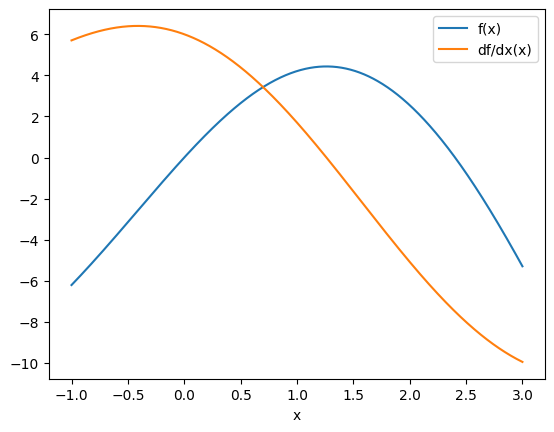

In [3]:
xs = jnp.linspace(-1, 3, 1001)
plt.plot(xs, f(xs), label="f(x)")
plt.plot(xs, df(xs), label="df/dx(x)")
plt.xlabel("x")
plt.legend()
plt.show()


Now let's use jax to compute the derivative for us and see how it compares to our analytical derivative.

We first call `jax.grad(f)`, which returns a new function that can be evaluated at `x` to give the derivative `df/dx(x)`.

For more details on `jax.grad` and the various other inputs it can take, refer to its documentation [here](https://jax.readthedocs.io/en/latest/_autosummary/jax.grad.html).

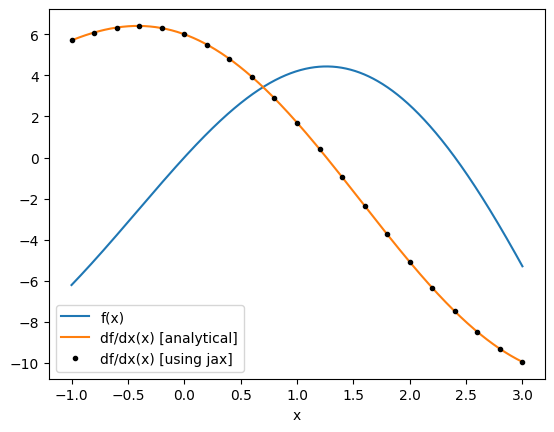

In [4]:
# get the gradient as a function of x
df_jax = jax.grad(f)

# get a set of points to feed the derivative function one by one (for now)
xs_jax = jnp.linspace(-1, 3, 21)
df_jax_eval = [df_jax(x) for x in xs_jax]

plt.plot(xs, f(xs), label="f(x)")
plt.plot(xs, df(xs), label="df/dx(x) [analytical]")
plt.plot(xs_jax, df_jax_eval, "k.", label="df/dx(x) [using jax]")
plt.xlabel("x")
plt.legend()
plt.show()


Note: `jax` provides several other useful gradient wrappers, which can be used in different contexts. 

For example [jax.value_and_grad](https://jax.readthedocs.io/en/latest/_autosummary/jax.value_and_grad.html) returns both the function return value and the gradient value, which is useful to avoid repetitive computation if you need the value as the `jax.grad` call must evaluate `f`.

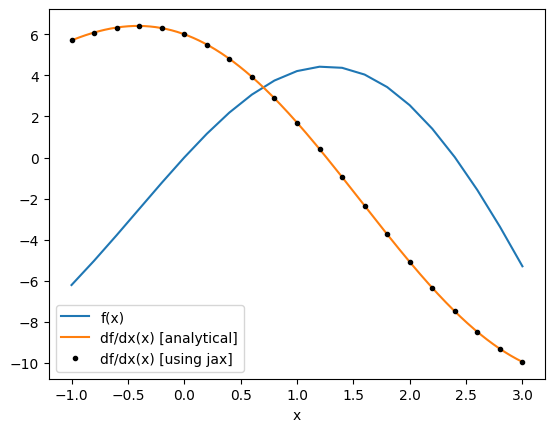

In [5]:
f_and_df = jax.value_and_grad(f)
vals_and_grads = [f_and_df(x) for x in xs_jax]
fs, dfs = list(zip(*vals_and_grads))

plt.plot(xs_jax, fs, label="f(x)")
plt.plot(xs, df(xs), label="df/dx(x) [analytical]")
plt.plot(xs_jax, df_jax_eval, "k.", label="df/dx(x) [using jax]")
plt.xlabel("x")
plt.legend()
plt.show()


We can also take an elementwise gradient using [jax.vmap](https://jax.readthedocs.io/en/latest/_autosummary/jax.vmap.html), which vectorizes our gradient function.

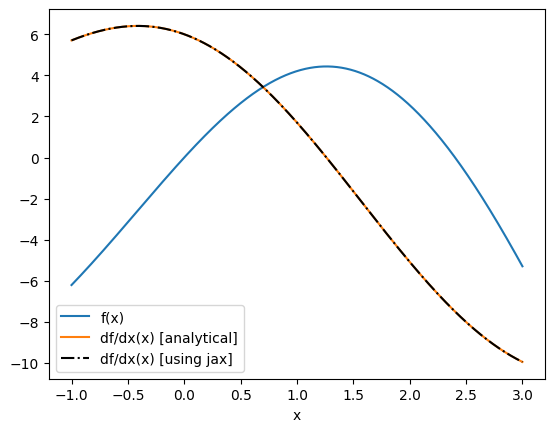

In [6]:
df_jax_vectorized = jax.vmap(jax.grad(f))

# get a set of points to feed the derivative function one by one (for now)
df_jax_eval = df_jax_vectorized(xs)

plt.plot(xs, f(xs), label="f(x)")
plt.plot(xs, df(xs), label="df/dx(x) [analytical]")
plt.plot(xs, df_jax_eval, "k-.", label="df/dx(x) [using jax]")
plt.xlabel("x")
plt.legend()
plt.show()


Before we continue, there are a few things to watch out for when using jax for gradient calculation:

1.  `jax.grad` outputs doesn't automatically convert input arguments from `int` to `float`, so avoid passing `int` types to your functions.

In [7]:
# ok
print(df_jax(1.0))

# errors
try:
    df_jax(1)
except TypeError as e:
    print(repr(e))


1.7015114
TypeError('grad requires real- or complex-valued inputs (input dtype that is a sub-dtype of np.inexact), but got int32. If you want to use Boolean- or integer-valued inputs, use vjp or set allow_int to True.')


2. When differentiating with respect to several arguments, you need to tell `jax.grad` which arguments you want to take the derivative with respect to as a tuple in indices. Otherwise it will take the derivative with respect to only the first argument.

In [8]:
def g(x, y, z):
    return x * y + z**2


# only gives dg/dx
dg = jax.grad(g)
dgdx = dg(1.0, 1.0, 1.0)
print(f"dgdx={dgdx}")

# gives derivative w.r.t. all three args
dg_all = jax.grad(g, argnums=(0, 1, 2))
dgdx, dgdy, dgdz = dg_all(1.0, 1.0, 1.0)
print(f"dgdx={dgdx}, dgdy={dgdy}, dgdz={dgdz}")


dgdx=1.0
dgdx=1.0, dgdy=1.0, dgdz=2.0


## Incorporating Automatic Differentiation in `Tidy3D`

With that basic introduction to automatic differentiation using `jax`, we can now show how the `tidy3d.plugins.adjoint`lets us do the same thing but where our functions can now involve setting up, running, and postprocessing a `tidy3d.Simulation`.

We'll need to import special `Jax` components from the adjoint plugin for this to work. These components are registered with `jax` so it knows how to handle them in its automatic differentiation pipeline.

We'll also need to import a special `web.run()` wrapper from the plugin. This [tidy3d.plugins.adjoint.web.run](../api/_autosummary/tidy3d.plugins.adjoint.web.run.html) function operates the same as `web.run()`, except its derivative rules are defined in the backend using the adjoint method. Thus, `jax` will know how to "differentiate" [tidy3d.plugins.adjoint.web.run](../api/_autosummary/tidy3d.plugins.adjoint.web.run.html) and it can be used within a function that we want to take derivatives with respect to.


Here is a diagram showing how the input arguments of our function `f` are related to the `JaxSimulation` and how the `JaxSimulationData` output of `tidy3d.plugins.adjoint.web.run` is related to the return value of `f`. This diagram can be a useful reference when moving through this section.

<img src="img/AdjointPipeline.png" width=800 alt="Diagram of the adjoint pipeline">

### Introducing `JaxSimuation`

Now we will show how to set up a very simple function using the adjoint plugin and differentiate it.

First, both our `Simulation` and some of its `.structures` may be dependent on the function arguments. Therefore, we need to use a special `Simulation` subclass called [JaxSimulation](../api/_autosummary/tidy3d.plugins.adjoint.JaxSimulation.html).

[JaxSimulation](../api/_autosummary/tidy3d.plugins.adjoint.JaxSimulation.html) is just a `jax`-compatible stand in for `Simulation` and behaves almost entirely the same, except for a few important differences:

1. it accepts an additional field `.input_structures`. These `input_structures` are tidy3d structures that can depend on the function arguments, and therefore need to be, `jax`-compatible, themselves. Thus, the structures used in this field must be of the `jax`-compatible type [JaxStructure](../api/_autosummary/tidy3d.plugins.adjoint.JaxStructure.html), which itself contains a `.medium` field of type [JaxMedium](../api/_autosummary/tidy3d.plugins.adjoint.JaxMedium.html) and a `.geometry` field that is of type [JaxBox](../api/_autosummary/tidy3d.plugins.adjoint.JaxBox.html). The `center`, `size`, and `permittivity` fields of these components may all depend on the function input arguments and the final gradients of the function will be given with respect to the values these fields.

> At the time of publishing, only `JaxStructures` with geometry of `JaxBox` are supported. However, the medium may contain [JaxMedium](../api/_autosummary/tidy3d.plugins.adjoint.JaxMedium.html), [JaxAnisotropicMedium](../api/_autosummary/tidy3d.plugins.adjoint.JaxAnisotropicMedium.html), or [JaxCustomMedium](../api/_autosummary/tidy3d.plugins.adjoint.JaxCustomMedium.html). 

> Any extraneous `Structures` can be added to the `JaxSimulation.structures` as long as they don't depend on the funciton arguments. These structures will still influence the simulation result as normal, but are "static". 

> The `input_structures` are always assumed to be added *on top of* the existing `.structures`.

2. it accepts another additional field `.output_monitors`, which define the set of monitors with corresponding data that the return value of our function will depend on. Note that at the time of writing, only `ModeMonitor` are supported.

3. to convert a `JaxSimulation` to a `Simulation`, one may call `sim, info = JaxSimulation.to_simulation()` where the `sim` is the `Simulation` with all `structures` and `monitors` put together and `info` is just a special information container that is needed to reconstruct the `JaxSimulation` from `sim` using `JaxSimulation.from_simulation(sim, info)`.

Let us now import these new `Jax` Tidy3d types and use them in an example.

In [9]:
import tidy3d as td
from tidy3d.plugins.adjoint import JaxSimulation, JaxStructure, JaxMedium, JaxBox


### Simulation example

In our example, we will set up a function that involves a simulation of transmission through a waveguide in the presence of a scatterer.

This scatterer geometry and material properties will depend on the function input arguments.

The output of the function will simply be the power transmitted into the 0th order mode.

We will then take the gradient of the output of this function (power) with respect to the scatterer geometric and medium properties using `jax`.

To start, it can often be helpful to break our function up into a few parts for debugging.

Therefore, we will introduce one function to make the `JaxSimulation` given the input arguments and one function to postprocess the result.

In [10]:
def make_simulation(center: float, size: float, eps: float) -> JaxSimulation:
    """Makes a simulation with a variable scatter width, height, and relative permittivity."""

    wavelength = 1.0
    freq0 = td.C_0 / wavelength
    dl = 0.02

    # a "static" structure
    waveguide = td.Structure(
        geometry=td.Box(size=(td.inf, 0.3, 0.2)), medium=td.Medium(permittivity=2.0)
    )

    # our "forward" soruce
    mode_src = td.ModeSource(
        size=(0, 1.5, 1.5),
        center=(-0.9, 0, 0),
        mode_index=0,
        source_time=td.GaussianPulse(freq0=freq0, fwidth=freq0 / 10),
        direction="+",
    )

    # a monitor to store data that our overall function will depend on
    mode_mnt = td.ModeMonitor(
        size=(0, 1.5, 1.5),
        center=(+0.9, 0, 0),
        mode_spec=mode_src.mode_spec,
        freqs=[freq0],
        name="mode",
    )

    # the structure that depends on the input parameters, which we will differentiate our function w.r.t
    scatterer = JaxStructure(
        geometry=JaxBox(
            center=center,
            size=size,
        ),
        medium=JaxMedium(permittivity=eps),
    )

    return JaxSimulation(
        size=(2, 2, 2),
        run_time=1e-12,
        structures=[waveguide],
        input_structures=[scatterer],
        sources=[mode_src],
        output_monitors=[mode_mnt],
        boundary_spec=td.BoundarySpec.all_sides(td.PML()),
        grid_spec=td.GridSpec.uniform(dl=dl),
    )


> Note: adding `.monitors` to the `JaxSimulation` will work as intended, but the function being differentiated should not depend on data corresponding to these monitors. This can, however,be useful for debugging, for example by examining field patterns, as the data will still be accessible in the output data.

Let's try setting up the simulation and plotting it for starters.

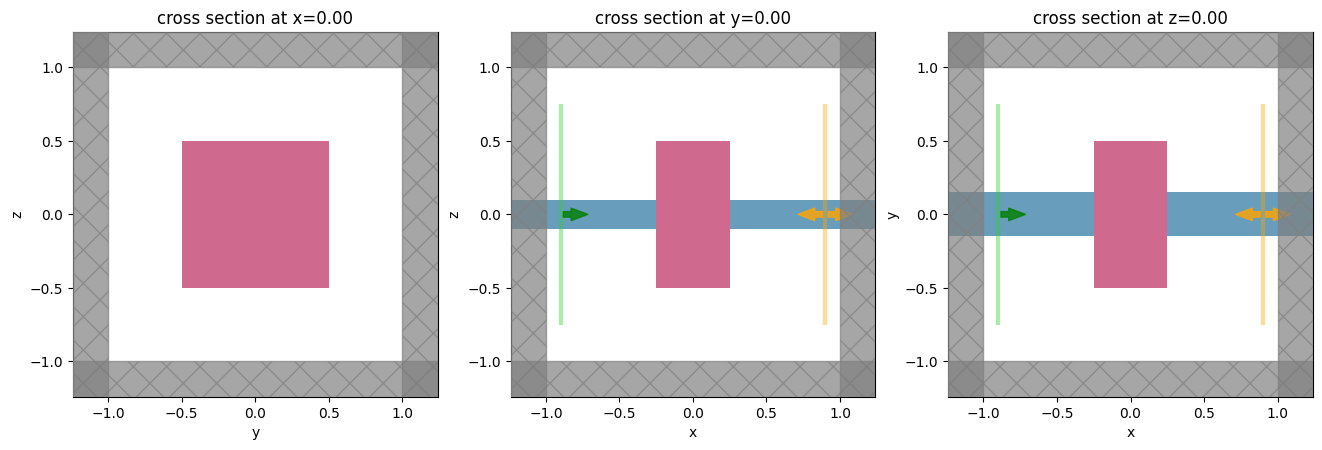

In [11]:
# starting set of input parameters
center0 = (0.0, 0.0, 0.0)
size0 = (0.5, 1.0, 1.0)
eps0 = 3.0

jax_sim = make_simulation(center=center0, size=size0, eps=eps0)
_, axes = plt.subplots(1, 3, figsize=(16, 5))

# sim, _ = jax_sim.to_simulation()
for ax, dim in zip(axes, "xyz"):
    jax_sim.plot(**{dim: 0}, ax=ax)
plt.show()


### Post-processing the output data

After the simulation is run, it returns a [JaxSimulation](../api/_autosummary/tidy3d.plugins.adjoint.JaxSimulation.html), which is a jax-compatible subclass of `SimulationData`. In addition to the `.data` corresponding to the `.monitors` in the `JaxSimulation`, `JaxSimulationData` also stores a `.output_data`, which stores the data corresponding to `JaxSimulation.output_monitors`. It is the `.output_data` that our differentiable function should depend on. These output data objects are also `Jax` subclasses of `Tidy3d` data objects, so their functionality may be slightly different, but overall can be used in the same way.

> Note: currently only `.sel()` selection is supported in jax-compatible DataArray objects. So you should use `.sel()` and pass the values you want to select instead of using `.interp()` or `isel()` 

Let's write a function that will postprocess our `JaxSimulationData` and return the power in the mode amplitude of our output mode monitor.

In [12]:
from tidy3d.plugins.adjoint import JaxSimulationData


def compute_power(jax_sim_data: JaxSimulationData) -> float:
    """Post process the result of the JaxSimulation run to return the power in the mode at index=0."""

    freq0 = jax_sim_data.simulation.output_monitors[0].freqs[0]
    jax_mode_data = jax_sim_data.output_monitor_data["mode"]
    mode_amps = jax_mode_data.amps
    amp = mode_amps.sel(direction="+", f=freq0, mode_index=0)
    return abs(amp) ** 2


### Defining the tidy3d simulation function for differentiation

Next, we can import the `tidy3d.plugins.adjoint.web.run` function and put all the pieces together into a single function to compute the 0th order transmitted power as a function of `center`, `size`, and `eps` (relative permittivty) of the scatterer.

In [13]:
from tidy3d.plugins.adjoint.web import run as run_adjoint


In [14]:
def power(center: float, size: float, eps: float) -> float:
    """Compute power transmitted into 0th order mode given a set of scatterer parameters."""
    jax_sim = make_simulation(center=center, size=size, eps=eps)
    jax_sim_data = run_adjoint(jax_sim, task_name="adjoint_power", verbose=True)
    return compute_power(jax_sim_data)


### Running and differentiating the simulation using `jax`

Finally, using the `jax` tools described earlier, we can differentiate this `power` function. 

For demonstration, let's use `jax.value_and_grad` to both compute the power **and** the gradient w.r.t. each of the 3 input parameters.

In [15]:
d_power = jax.value_and_grad(power, argnums=(0, 1, 2))


We will run this function and assign variables to the power values and the gradients returned.

Note that running this will set off **two** separate tasks, one after another, called, `"adjoint_power_fwd"` and `"adjoint_power_adj"`.

The first is evaluating our simulation in "forward mode", computing the power and stashing information needed for gradient computation.

The second step runs the "adjoint" simulation, in which the output monitor is converted to a source and the simulation is re-run.

The results of both of these simulations runs are combined behind the scene to tell jax how to compute the gradient for us.

In [16]:
power_value, (dp_center, dp_dsize, dp_deps) = d_power(center0, size0, eps0)


12:30:22 CET Created task 'adjoint_power' with task_id                          
             'fdve-10043eda-72b6-45fe-99cb-603363c25559' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=469187;https://tidy3d.simulation.cloud/workbench?taskId=fdve-10043eda-72b6-45fe-99cb-603363c25559\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=564278;https://tidy3d.simulation.cloud/workbench?taskId=fdve-10043eda-72b6-45fe-99cb-603363c25559\taskId]8;;\]8;id=469187;https://tidy3d.simulation.cloud/workbench?taskId=fdve-10043eda-72b6-45fe-99cb-603363c25559\=]8;;\]8;id=185041;https://tidy3d.simulation.cloud/workbench?taskId=fdve-10043eda-72b6-45fe-99cb-603363c25559\fdve]8;;\]8;id=469187;https://tidy3d.simulation.cloud/workbench?taskId=fdve-10043eda-72b6-45fe-99cb-603363c25559\-10043eda-72b]8;;\
             ]8;id=469187;https://tidy3d.simulation.cloud/workbench?taskId=fdve-10043eda-72b6-45fe-99cb-603363c25559\6-45fe-99cb-603363c25559']8;;\.

Output()

Output()

12:30:27 CET status = queued

Output()

12:30:33 CET status = preprocess

12:30:34 CET Maximum FlexCredit cost: 0.025. Use 'web.real_cost(task_id)' to get
             the billed FlexCredit cost after a simulation run.

             starting up solver

12:30:35 CET running solver

             To cancel the simulation, use 'web.abort(task_id)' or              
             'web.delete(task_id)' or abort/delete the task in the web UI.      
             Terminating the Python script will not stop the job running on the 
             cloud.

Output()

12:30:40 CET early shutoff detected at 8%, exiting.

12:30:41 CET status = postprocess

Output()

12:30:46 CET status = success

             View simulation result at                                          
             ]8;id=852692;https://tidy3d.simulation.cloud/workbench?taskId=fdve-10043eda-72b6-45fe-99cb-603363c25559\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=282390;https://tidy3d.simulation.cloud/workbench?taskId=fdve-10043eda-72b6-45fe-99cb-603363c25559\taskId]8;;\]8;id=852692;https://tidy3d.simulation.cloud/workbench?taskId=fdve-10043eda-72b6-45fe-99cb-603363c25559\=]8;;\]8;id=408679;https://tidy3d.simulation.cloud/workbench?taskId=fdve-10043eda-72b6-45fe-99cb-603363c25559\fdve]8;;\]8;id=852692;https://tidy3d.simulation.cloud/workbench?taskId=fdve-10043eda-72b6-45fe-99cb-603363c25559\-10043eda-72b]8;;\
             ]8;id=852692;https://tidy3d.simulation.cloud/workbench?taskId=fdve-10043eda-72b6-45fe-99cb-603363c25559\6-45fe-99cb-603363c25559']8;;\.

Output()

12:30:48 CET loading simulation from simulation_data.hdf5

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

12:30:49 CET Created task 'adjoint_power_adj' with task_id                      
             'fdve-2159c212-b30b-4b27-8ca1-2337ed7916ed' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=319087;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2159c212-b30b-4b27-8ca1-2337ed7916ed\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=261800;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2159c212-b30b-4b27-8ca1-2337ed7916ed\taskId]8;;\]8;id=319087;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2159c212-b30b-4b27-8ca1-2337ed7916ed\=]8;;\]8;id=535801;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2159c212-b30b-4b27-8ca1-2337ed7916ed\fdve]8;;\]8;id=319087;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2159c212-b30b-4b27-8ca1-2337ed7916ed\-2159c212-b30]8;;\
             ]8;id=319087;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2159c212-b30b-4b27-8ca1-2337ed7916ed\b-4b27-8ca1-2337ed7916ed']8;;\.

Output()

Output()

12:30:53 CET status = queued

Output()

12:30:57 CET status = preprocess

12:30:58 CET Maximum FlexCredit cost: 0.057. Use 'web.real_cost(task_id)' to get
             the billed FlexCredit cost after a simulation run.

             starting up solver

12:30:59 CET running solver

             To cancel the simulation, use 'web.abort(task_id)' or              
             'web.delete(task_id)' or abort/delete the task in the web UI.      
             Terminating the Python script will not stop the job running on the 
             cloud.

Output()

12:31:06 CET early shutoff detected at 4%, exiting.

             status = postprocess

Output()

12:31:08 CET status = success

             View simulation result at                                          
             ]8;id=161080;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2159c212-b30b-4b27-8ca1-2337ed7916ed\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=120407;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2159c212-b30b-4b27-8ca1-2337ed7916ed\taskId]8;;\]8;id=161080;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2159c212-b30b-4b27-8ca1-2337ed7916ed\=]8;;\]8;id=31379;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2159c212-b30b-4b27-8ca1-2337ed7916ed\fdve]8;;\]8;id=161080;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2159c212-b30b-4b27-8ca1-2337ed7916ed\-2159c212-b30]8;;\
             ]8;id=161080;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2159c212-b30b-4b27-8ca1-2337ed7916ed\b-4b27-8ca1-2337ed7916ed']8;;\.

Output()

> Note: the gradient evaluation functions returned by `jax.grad()` do not accept keyword arguments (ie. `center=(0.,0.,0.)`) and instead accept positional arguments (without the argument name). You may run across this when trying to evaluate gradients so it's a good idea to keep in mind.

We can take a look at our computed power and gradient information. 

In [17]:
print(f"power = {power_value:.3f}")
print(f"d_power/d_center = {dp_center}")
print(f"d_power/d_size = {dp_dsize}")
print(f"d_power/d_eps = {dp_deps}")


power = 0.552
d_power/d_center = (-0.0063285101137246225, 1.169491113289789e-05, -0.0005401665341729089)
d_power/d_size = (-0.027093325100316326, 0.1321369111905392, -0.133587128331337)
d_power/d_eps = -0.1680526223554213


From this, we can infer several things that fit our intuition, for example that:
* the transmitted power should **decrease** if we increase the permittivity of our scatterer.
* the transmitted power does not depend strongly on the position of the scatterer along the propagation direction.

## Conclusion & Next Steps

This gives the most basic introduction to the principles behind the adjoint plugin.

In subsequent notebooks, we will show how to:
 * Check the gradients returned by this method against brute force computed gradients for accuracy.
 * Perform gradient-based optimization using the adjoint plugin.